In [ ]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, asin

# Datos iniciales
num_properties_airbnb = 7700000
num_hosts_airbnb = 5000000
num_houses_gov = 12700
population_gov = 11500
annual_visits_gov = 1392226

# Pesos para Airbnb y Gobierno
w1, w2 = 0.6, 0.4
w3, w4, w5 = 0.4, 0.3, 0.3

# Calcular masa de Airbnb
mass_airbnb = w1 * num_properties_airbnb + w2 * num_hosts_airbnb

# Calcular masa del Gobierno
mass_government = w3 * num_houses_gov + w4 * population_gov + w5 * annual_visits_gov

# Función para calcular la distancia Haversine
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radio de la Tierra en km
    phi1, phi2 = radians(lat1), radians(lat2)
    dphi = radians(lat2 - lat1)
    dlambda = radians(lon2 - lon1)
    a = sin(dphi / 2)**2 + cos(phi1) * cos(phi2) * sin(dlambda / 2)**2
    c = 2 * asin(sqrt(a))
    return R * c

# Cargar datos
df = pd.read_excel("/content/para red social 998 registros.xlsx")

# Calcular masa del host
def calculate_host_mass(host_data):
    mass = 0

    # Nombre del host
    name_count = df['host_name'].value_counts().get(host_data['host_name'], 0)
    mass += name_count

    # Superhost
    if host_data['Superhost']:
        mass += 2
    else:
        mass += 1

    # Cohosts
    cohosts = sum(1 for col in ['cohosts_1', 'cohosts_2', 'cohosts_3'] if pd.notnull(host_data[col]))
    mass += cohosts

    # Ubicación del host
    location = host_data['host_location']
    if isinstance(location, str):
        if 'mexico' in location.lower():
            mass += 3
        else:
            mass += 2
    else:
        mass += 0

    # Otros valores numéricos
    mass += host_data['host_rating']
    mass += host_data['host_Count']
    mass += host_data['host_years']
    mass += host_data['reviewsCount']

    return mass

# Calcular masa de cada propiedad
def calculate_property_mass(property_data, host_mass):
    mass = host_mass

    # room_Category
    if property_data['room_Category'] == 'entire_home':
        mass += 3
    elif property_data['room_Category'] == 'private_room':
        mass += 1

    # Listing_Rating, Reviews, maxGuest
    mass += property_data['Listing_Rating']
    mass += property_data['Reviews']
    mass += property_data['maxGuest']

    # petsAllowed
    if property_data['petsAllowed']:
        mass += 2

    # canInstantBook
    if property_data['canInstantBook']:
        mass += 2

    # Amenities
    amenities_columns = [f'amenities/{i}/title' for i in range(10)]
    if any('pool' in str(property_data[col]).lower() for col in amenities_columns):
        mass += 1

    return mass

# Aplicar función para calcular masa del host
df['Host_Mass'] = df.apply(calculate_host_mass, axis=1)

# Aplicar función para calcular masa de la propiedad usando la masa del host
df['Property_Mass'] = df.apply(lambda row: calculate_property_mass(row, row['Host_Mass']), axis=1)

# Inicializar matriz de fuerzas
n = len(df)
fuerzas = np.zeros((n, n))

# Calcular fuerzas de atracción
for i in range(n):
    for j in range(i + 1, n):
        dist = haversine(
            df.iloc[i]['coordinate/latitude'],
            df.iloc[i]['coordinate/longitude'],
            df.iloc[j]['coordinate/latitude'],
            df.iloc[j]['coordinate/longitude']
        )
        if dist > 0:
            fuerza = (df.iloc[i]['Property_Mass'] * df.iloc[j]['Property_Mass']) / (dist**2)
            fuerzas[i, j] = fuerza
            fuerzas[j, i] = fuerza

# Sumar fuerzas totales para cada propiedad
df['Fuerza_Total'] = fuerzas.sum(axis=1)

# Identificar propiedades con mayor gravedad
propiedades_top = df.sort_values(by='Fuerza_Total', ascending=False).head(10)

# Identificar anfitriones con mayor influencia
anfitriones_top = df.groupby('host_name')['Property_Mass'].sum().sort_values(ascending=False).head(10)

print("Propiedades con mayor gravedad:")
print(propiedades_top[['location/title', 'Fuerza_Total']])

print("\nAnfitriones con mayor influencia:")
print(anfitriones_top)

Propiedades con mayor gravedad:
           location/title  Fuerza_Total
0                  Ajijic           NaN
1                  Ajijic           NaN
2                  Ajijic           NaN
3  San Antonio Tlayacapan           NaN
4                  Ajijic           NaN
5                  Ajijic           NaN
6                  Ajijic           NaN
7                  Ajijic           NaN
8                  Ajijic           NaN
9                  Ajijic           NaN

Anfitriones con mayor influencia:
host_name
Colin               8436.71
Lirio               6974.28
Ana Laura           5172.81
Romy                4443.67
Iliana Guadalupe    3555.78
Jose Ernesto        3295.24
Santiago            3161.31
John                3131.53
Fénix               2555.06
Maria Teresa        2534.84
Name: Property_Mass, dtype: float64


In [ ]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, asin
import geopandas as gpd
from shapely.geometry import Point, LineString
!pip install simplekml # install the simplekml package
import simplekml # import the simplekml module after installing

# Datos iniciales
num_properties_airbnb = 7700000
num_hosts_airbnb = 5000000
num_houses_gov = 12700
population_gov = 11500
annual_visits_gov = 1392226

# Pesos para Airbnb y Gobierno
w1, w2 = 0.6, 0.4
w3, w4, w5 = 0.4, 0.3, 0.3

# Calcular masa de Airbnb
mass_airbnb = w1 * num_properties_airbnb + w2 * num_hosts_airbnb

# Calcular masa del Gobierno
mass_government = w3 * num_houses_gov + w4 * population_gov + w5 * annual_visits_gov

# Función para calcular la distancia Haversine
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radio de la Tierra en km
    phi1, phi2 = radians(lat1), radians(lat2)
    dphi = radians(lat2 - lat1)
    dlambda = radians(lon2 - lon1)
    a = sin(dphi / 2)**2 + cos(phi1) * cos(phi2) * sin(dlambda / 2)**2
    c = 2 * asin(sqrt(a))
    return R * c

# Cargar datos
df = pd.read_excel("/content/para red social 998 registros.xlsx")

# Calcular masa del host
def calculate_host_mass(host_data):
    mass = 0

    # Nombre del host
    name_count = df['host_name'].value_counts().get(host_data['host_name'], 0)
    mass += name_count

    # Superhost
    if host_data['Superhost']:
        mass += 2
    else:
        mass += 1

    # Cohosts
    cohosts = sum(1 for col in ['cohosts_1', 'cohosts_2', 'cohosts_3'] if pd.notnull(host_data[col]))
    mass += cohosts

    # Ubicación del host
    location = host_data['host_location']
    if isinstance(location, str):
        if 'mexico' in location.lower():
            mass += 3
        else:
            mass += 2
    else:
        mass += 0

    # Otros valores numéricos
    mass += host_data['host_rating']
    mass += host_data['host_Count']
    mass += host_data['host_years']
    mass += host_data['reviewsCount']

    return mass

# Calcular masa de cada propiedad
def calculate_property_mass(property_data, host_mass):
    mass = host_mass

    # room_Category
    if property_data['room_Category'] == 'entire_home':
        mass += 3
    elif property_data['room_Category'] == 'private_room':
        mass += 1

    # Listing_Rating, Reviews, maxGuest
    mass += property_data['Listing_Rating']
    mass += property_data['Reviews']
    mass += property_data['maxGuest']

    # petsAllowed
    if property_data['petsAllowed']:
        mass += 2

    # canInstantBook
    if property_data['canInstantBook']:
        mass += 2

    # Amenities
    amenities_columns = [f'amenities/{i}/title' for i in range(10)]
    if any('pool' in str(property_data[col]).lower() for col in amenities_columns):
        mass += 1

    return mass

# Aplicar función para calcular masa del host
df['Host_Mass'] = df.apply(calculate_host_mass, axis=1)

# Aplicar función para calcular masa de la propiedad usando la masa del host
df['Property_Mass'] = df.apply(lambda row: calculate_property_mass(row, row['Host_Mass']), axis=1)

# Inicializar matriz de fuerzas
n = len(df)
fuerzas = np.zeros((n, n))

# Calcular fuerzas de atracción
for i in range(n):
    for j in range(i + 1, n):
        dist = haversine(
            df.iloc[i]['coordinate/latitude'],
            df.iloc[i]['coordinate/longitude'],
            df.iloc[j]['coordinate/latitude'],
            df.iloc[j]['coordinate/longitude']
        )
        if dist > 0:
            fuerza = (df.iloc[i]['Property_Mass'] * df.iloc[j]['Property_Mass']) / (dist**2)
            fuerzas[i, j] = fuerza
            fuerzas[j, i] = fuerza

# Sumar fuerzas totales para cada propiedad
df['Fuerza_Total'] = fuerzas.sum(axis=1)

# Identificar propiedades con mayor gravedad
propiedades_top = df.sort_values(by='Fuerza_Total', ascending=False).head(10)

# Identificar anfitriones con mayor influencia
anfitriones_top = df.groupby('host_name')['Property_Mass'].sum().sort_values(ascending=False).head(10)

print("Propiedades con mayor gravedad:")
print(propiedades_top[['location/title', 'Fuerza_Total']])

print("\nAnfitriones con mayor influencia:")
print(anfitriones_top)

# Exportar información de las propiedades en CSV
df.to_csv("propiedades.csv", index=False)

# Exportar información de las propiedades en SHP
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['coordinate/longitude'], df['coordinate/latitude']),
    crs="EPSG:4326"
)
gdf.to_file("propiedades.shp")

# Exportar información de las propiedades en KML
kml = simplekml.Kml()
for idx, row in df.iterrows():
    point = kml.newpoint(
        name=row['location/title'],
        coords=[(row['coordinate/longitude'], row['coordinate/latitude'])]
    )
    point.extendeddata.newdata("Masa", row['Property_Mass'])
    point.extendeddata.newdata("Gravedad", row['Fuerza_Total'])

kml.save("propiedades.kml")

# Crear capa de aristas
edges = []
for i in range(n):
    for j in range(i + 1, n):
        if fuerzas[i, j] > 0:
            edges.append({
                'Origen': df.iloc[i]['Listing_id'],
                'Destino': df.iloc[j]['Listing_id'],
                'Gravedad_Conductual': fuerzas[i, j],
                'geometry': LineString([
                    (df.iloc[i]['coordinate/longitude'], df.iloc[i]['coordinate/latitude']),
                    (df.iloc[j]['coordinate/longitude'], df.iloc[j]['coordinate/latitude'])
                ])
            })

edges_df = pd.DataFrame(edges)
edges_gdf = gpd.GeoDataFrame(edges_df, geometry='geometry', crs="EPSG:4326")
edges_gdf.to_file("aristas.shp")

print("Exportación completada.")

Propiedades con mayor gravedad:
           location/title  Fuerza_Total
0                  Ajijic           NaN
1                  Ajijic           NaN
2                  Ajijic           NaN
3  San Antonio Tlayacapan           NaN
4                  Ajijic           NaN
5                  Ajijic           NaN
6                  Ajijic           NaN
7                  Ajijic           NaN
8                  Ajijic           NaN
9                  Ajijic           NaN

Anfitriones con mayor influencia:
host_name
Colin               8436.71
Lirio               6974.28
Ana Laura           5172.81
Romy                4443.67
Iliana Guadalupe    3555.78
Jose Ernesto        3295.24
Santiago            3161.31
John                3131.53
Fénix               2555.06
Maria Teresa        2534.84
Name: Property_Mass, dtype: float64


<ipython-input-4-c217159a4464>:153: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("propiedades.shp")
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'location/title' to 'location/t'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'room_Category' to 'room_Categ'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Listing_Rating' to 'Listing_Ra'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'petsAllowed' to 'petsAllowe'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'canInstantBook' to 'canInstant'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: 

Exportación completada.


/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 1219403852.18733954 of field Gravedad_C of feature 33808 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 896958886.91010499 of field Gravedad_C of feature 33809 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 933595936.422455668 of field Gravedad_C of feature 33810 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 1037429746.75822628 of field Gravedad_C of feature 33811 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/p

Análisis estadístico descriptivo:
           Listing_id location/title room_Category  Listing_Rating     Reviews  \
count   3.200000e+02            317           317      320.000000  320.000000   
unique           NaN             15             2             NaN         NaN   
top              NaN         Ajijic   entire_home             NaN         NaN   
freq             NaN            211           275             NaN         NaN   
mean    5.091790e+17            NaN           NaN        4.559687   54.465625   
std     5.110854e+17            NaN           NaN        1.156144   56.972292   
min     1.701750e+05            NaN           NaN        0.000000    0.000000   
25%     3.892277e+07            NaN           NaN        4.750000   12.000000   
50%     5.702779e+17            NaN           NaN        4.865000   37.000000   
75%     9.906125e+17            NaN           NaN        4.942500   80.000000   
max     1.342222e+18            NaN           NaN        5.000000  360.000

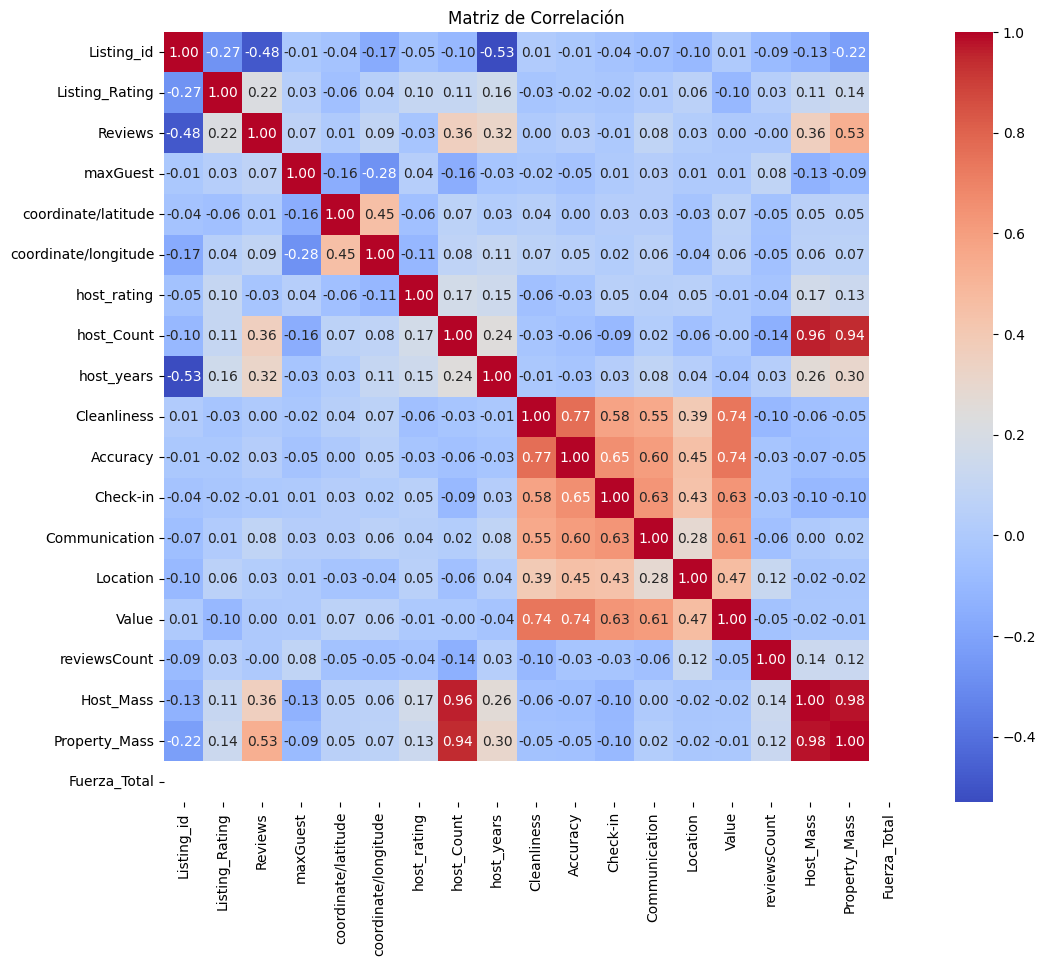


Matriz de correlación de variables numéricas:
                 Property_Mass  Fuerza_Total  Host_Mass  Listing_Rating  \
Property_Mass        1.000000           NaN   0.980286        0.138386   
Fuerza_Total              NaN           NaN        NaN             NaN   
Host_Mass            0.980286           NaN   1.000000        0.112652   
Listing_Rating       0.138386           NaN   0.112652        1.000000   
Reviews              0.530565           NaN   0.355371        0.219585   
maxGuest            -0.090633           NaN  -0.132703        0.031970   
host_rating          0.134688           NaN   0.167616        0.103642   
host_Count           0.944436           NaN   0.960451        0.108439   
host_years           0.301400           NaN   0.263800        0.156253   
reviewsCount         0.121680           NaN   0.136294        0.033605   

                 Reviews  maxGuest  host_rating  host_Count  host_years  \
Property_Mass   0.530565 -0.090633     0.134688    0.944436   

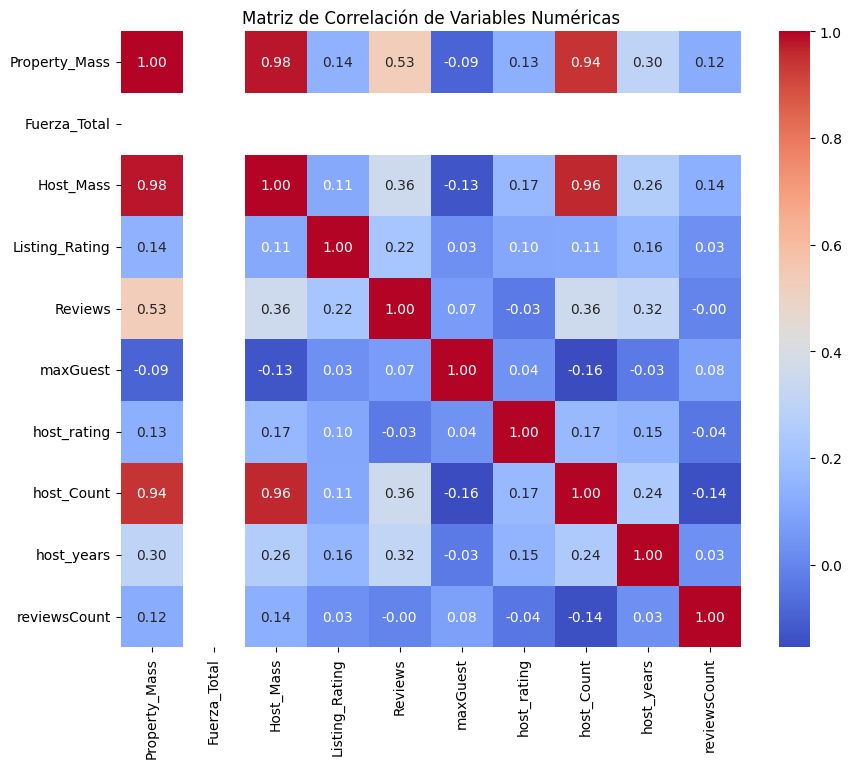


Explicación de los resultados:
La matriz de correlación muestra la relación lineal entre pares de variables. Los valores oscilan entre -1 y 1.  Valores cercanos a 1 indican una correlación positiva fuerte, valores cercanos a -1 indican una correlación negativa fuerte, y valores cercanos a 0 indican una correlación débil o inexistente.
La matriz de correlación de las variables numéricas proporciona una visión más específica de las relaciones entre estas variables.
Existe una correlacion notable entre Listing_id y host_years (valor = -0.53).
Existe una correlacion notable entre Reviews y Property_Mass (valor = 0.53).
Existe una correlacion notable entre host_Count y Host_Mass (valor = 0.96).
Existe una correlacion notable entre host_Count y Property_Mass (valor = 0.94).
Existe una correlacion notable entre host_years y Listing_id (valor = -0.53).
Existe una correlacion notable entre Cleanliness y Accuracy (valor = 0.77).
Existe una correlacion notable entre Cleanliness y Check-in (valor

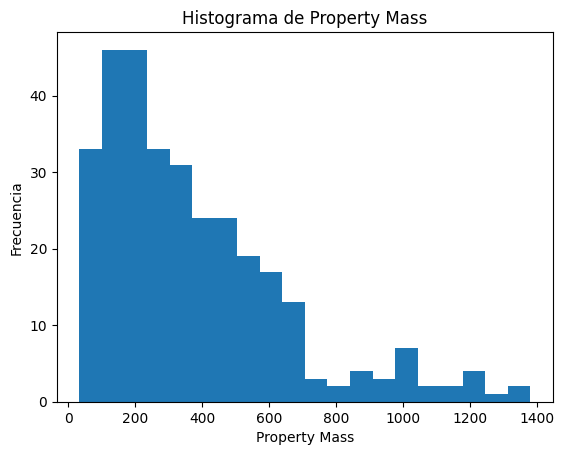

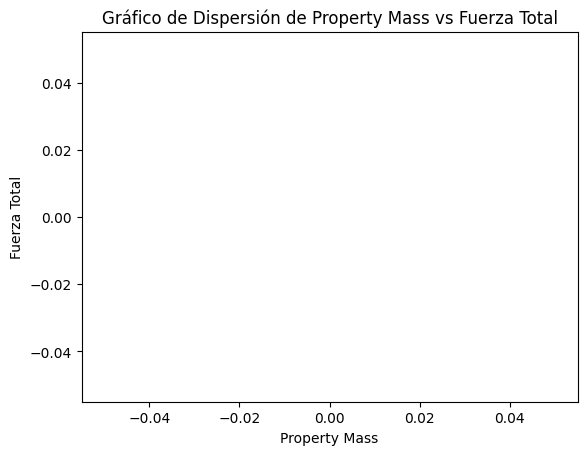

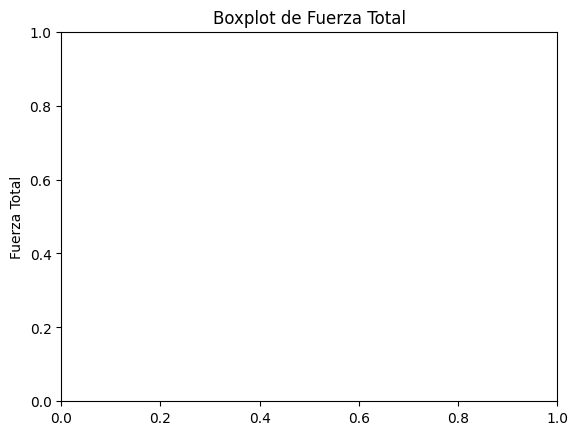

In [ ]:
# prompt: lee el csv en /content/propiedades.csv y realiza un analisis estadistico completo y de correlacion y que explique el resultado de cada valor, incluye graficos

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Lee el archivo CSV
df = pd.read_csv('/content/propiedades.csv')

# Análisis estadístico descriptivo
print("Análisis estadístico descriptivo:\n", df.describe(include='all'))

# Análisis de correlación
# Select only numerical features for correlation analysis
numerical_df = df.select_dtypes(include=np.number)

correlation_matrix = numerical_df.corr()
print("\nMatriz de correlación:\n", correlation_matrix)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()


# Análisis de correlación para variables numéricas específicas (ejemplo)
numeric_cols = ['Property_Mass', 'Fuerza_Total', 'Host_Mass', 'Listing_Rating', 'Reviews', 'maxGuest', 'host_rating', 'host_Count','host_years', 'reviewsCount']
correlation_numeric = df[numeric_cols].corr()
print("\nMatriz de correlación de variables numéricas:\n", correlation_numeric)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_numeric, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Variables Numéricas')
plt.show()


# Explicación de los resultados
print("\nExplicación de los resultados:")

# Describe la matriz de correlación
print("La matriz de correlación muestra la relación lineal entre pares de variables. Los valores oscilan entre -1 y 1.  Valores cercanos a 1 indican una correlación positiva fuerte, valores cercanos a -1 indican una correlación negativa fuerte, y valores cercanos a 0 indican una correlación débil o inexistente.")

# Describe la matriz de correlación de variables numéricas
print("La matriz de correlación de las variables numéricas proporciona una visión más específica de las relaciones entre estas variables.")

# Itera sobre la matriz de correlacion para dar ejemplos
for col1 in correlation_matrix.columns:
  for col2 in correlation_matrix.columns:
      if col1 != col2 and abs(correlation_matrix[col1][col2]) > 0.5: # Filtra correlaciones fuertes
          print(f"Existe una correlacion notable entre {col1} y {col2} (valor = {correlation_matrix[col1][col2]:.2f}).")


# Ejemplos de gráficos adicionales (ajusta según tus necesidades)
# Histograma de 'Property_Mass'
plt.figure()
plt.hist(df['Property_Mass'], bins=20)
plt.xlabel('Property Mass')
plt.ylabel('Frecuencia')
plt.title('Histograma de Property Mass')
plt.show()

# Gráfico de dispersión de 'Property_Mass' vs 'Fuerza_Total'
plt.figure()
plt.scatter(df['Property_Mass'], df['Fuerza_Total'])
plt.xlabel('Property Mass')
plt.ylabel('Fuerza Total')
plt.title('Gráfico de Dispersión de Property Mass vs Fuerza Total')
plt.show()

# Boxplot de 'Fuerza_Total'
plt.figure()
# Drop NaN values before plotting to ensure data consistency
sns.boxplot(y=df['Fuerza_Total'].dropna())  # Added .dropna()
plt.ylabel('Fuerza Total')
plt.title('Boxplot de Fuerza Total')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, asin
import geopandas as gpd
from shapely.geometry import Point, LineString
!pip install simplekml # install the simplekml package
import simplekml # import the simplekml module after installing


# Define haversine function here, before the loop that uses it:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radio de la Tierra en km
    phi1, phi2 = radians(lat1), radians(lat2)
    dphi = radians(lat2 - lat1)
    dlambda = radians(lon2 - lon1)
    a = sin(dphi / 2)**2 + cos(phi1) * cos(phi2) * sin(dlambda / 2)**2
    c = 2 * asin(sqrt(a))
    return R * c

# Cargar datos  (Assuming this is where your df is loaded)
df = pd.read_excel("/content/para red social 998 registros.xlsx")

# Calcular masa del host
def calculate_host_mass(host_data):
    # ... (function code) ...
    mass = 0

    # Nombre del host
    name_count = df['host_name'].value_counts().get(host_data['host_name'], 0)
    mass += name_count

    # Superhost
    if host_data['Superhost']:
        mass += 2
    else:
        mass += 1

    # Cohosts
    cohosts = sum(1 for col in ['cohosts_1', 'cohosts_2', 'cohosts_3'] if pd.notnull(host_data[col]))
    mass += cohosts

    # Ubicación del host
    location = host_data['host_location']
    if isinstance(location, str):
        if 'mexico' in location.lower():
            mass += 3
        else:
            mass += 2
    else:
        mass += 0

    # Otros valores numéricos
    mass += host_data['host_rating']
    mass += host_data['host_Count']
    mass += host_data['host_years']
    mass += host_data['reviewsCount']

    return mass

# Calcular masa de cada propiedad
def calculate_property_mass(property_data, host_mass):
    # ... (function code) ...
    mass = host_mass

    # room_Category
    if property_data['room_Category'] == 'entire_home':
        mass += 3
    elif property_data['room_Category'] == 'private_room':
        mass += 1

    # Listing_Rating, Reviews, maxGuest
    mass += property_data['Listing_Rating']
    mass += property_data['Reviews']
    mass += property_data['maxGuest']

    # petsAllowed
    if property_data['petsAllowed']:
        mass += 2

    # canInstantBook
    if property_data['canInstantBook']:
        mass += 2

    # Amenities
    amenities_columns = [f'amenities/{i}/title' for i in range(10)]
    if any('pool' in str(property_data[col]).lower() for col in amenities_columns):
        mass += 1

    return mass

# Aplicar función para calcular masa del host
df['Host_Mass'] = df.apply(calculate_host_mass, axis=1)

# Aplicar función para calcular masa de la propiedad usando la masa del host
df['Property_Mass'] = df.apply(lambda row: calculate_property_mass(row, row['Host_Mass']), axis=1)

# ... (Rest of your code) ...

# Inicializar matriz de fuerzas
n = len(df)
fuerzas = np.zeros((n, n))

# Calcular fuerzas de atracción
for i in range(n):
    for j in range(i + 1, n):
        try:
            # Convert coordinates to numeric, handling potential errors
            lat1 = float(df.iloc[i]['coordinate/latitude'])
            lon1 = float(df.iloc[i]['coordinate/longitude'])
            lat2 = float(df.iloc[j]['coordinate/latitude'])
            lon2 = float(df.iloc[j]['coordinate/longitude'])

            # Check if coordinates are valid numbers
            if pd.isnull(lat1) or pd.isnull(lon1) or pd.isnull(lat2) or pd.isnull(lon2):
                print(f"Invalid coordinates for index {i} or {j}")
                continue

            dist = haversine(lat1, lon1, lat2, lon2)

            # Avoid division by zero
            if dist > 0:
                mass_i = df.iloc[i]['Property_Mass']
                mass_j = df.iloc[j]['Property_Mass']

                # Ensure masses are not NaN or zero
                if pd.notnull(mass_i) and pd.notnull(mass_j) and mass_i != 0 and mass_j != 0:
                    fuerza = (mass_i * mass_j) / (dist**2)
                    fuerzas[i, j] = fuerza
                    fuerzas[j, i] = fuerza
                else:
                    print(f"Invalid masses for index {i} or {j}: Mass_i={mass_i}, Mass_j={mass_j}")
            else:
                # Handle zero distance, e.g., set a small value to avoid division by zero:
                # You might want to log or investigate why the distance is 0.
                print(f"Zero distance between indices {i} and {j}")

        except ValueError as e:
            print(f"Error processing coordinates for index {i} or {j}: {e}")
            continue

# Sumar fuerzas totales para cada propiedad
df['Fuerza_Total'] = fuerzas.sum(axis=1)

# Identificar propiedades con mayor gravedad
propiedades_top = df.sort_values(by='Fuerza_Total', ascending=False).head(10)

# Identificar anfitriones con mayor influencia
anfitriones_top = df.groupby('host_name')['Property_Mass'].sum().sort_values(ascending=False).head(10)

print("Propiedades con mayor gravedad:")
print(propiedades_top[['location/title', 'Fuerza_Total']])
print("\nAnfitriones con mayor influencia:")
print(anfitriones_top)

# Exportar información de las propiedades en CSV
df.to_csv("propiedades.csv", index=False)

# Exportar información de las propiedades en SHP
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['coordinate/longitude'], df['coordinate/latitude']),
    crs="EPSG:4326"
)
gdf.to_file("propiedades.shp")

# Exportar información de las propiedades en KML
kml = simplekml.Kml()
for idx, row in df.iterrows():
    point = kml.newpoint(
        name=row['location/title'],
        coords=[(row['coordinate/longitude'], row['coordinate/latitude'])]
    )
    point.extendeddata.newdata("Masa", row['Property_Mass'])
    point.extendeddata.newdata("Gravedad", row['Fuerza_Total'])
kml.save("propiedades.kml")

# Crear capa de aristas
edges = []
for i in range(n):
    for j in range(i + 1, n):
        if fuerzas[i, j] > 0:
            edges.append({
                'Origen': df.iloc[i]['Listing_id'],
                'Destino': df.iloc[j]['Listing_id'],
                'Gravedad_Conductual': fuerzas[i, j],
                'geometry': LineString([
                    (df.iloc[i]['coordinate/longitude'], df.iloc[i]['coordinate/latitude']),
                    (df.iloc[j]['coordinate/longitude'], df.iloc[j]['coordinate/latitude'])
                ])
            })
edges_df = pd.DataFrame(edges)
edges_gdf = gpd.GeoDataFrame(edges_df, geometry='geometry', crs="EPSG:4326")
edges_gdf.to_file("aristas.shp")

print("Exportación completada.")

Invalid masses for index 0 or 195: Mass_i=438.92, Mass_j=nan
Invalid masses for index 0 or 252: Mass_i=438.92, Mass_j=nan
Invalid masses for index 0 or 253: Mass_i=438.92, Mass_j=nan
Invalid masses for index 0 or 254: Mass_i=438.92, Mass_j=nan
Zero distance between indices 1 and 2
Invalid masses for index 1 or 195: Mass_i=236.68, Mass_j=nan
Invalid masses for index 1 or 252: Mass_i=236.68, Mass_j=nan
Invalid masses for index 1 or 253: Mass_i=236.68, Mass_j=nan
Invalid masses for index 1 or 254: Mass_i=236.68, Mass_j=nan
Invalid masses for index 2 or 195: Mass_i=412.64000000000004, Mass_j=nan
Invalid masses for index 2 or 252: Mass_i=412.64000000000004, Mass_j=nan
Invalid masses for index 2 or 253: Mass_i=412.64000000000004, Mass_j=nan
Invalid masses for index 2 or 254: Mass_i=412.64000000000004, Mass_j=nan
Invalid masses for index 3 or 195: Mass_i=206.0, Mass_j=nan
Invalid masses for index 3 or 252: Mass_i=206.0, Mass_j=nan
Invalid masses for index 3 or 253: Mass_i=206.0, Mass_j=nan
In

<ipython-input-14-089d172f519d>:164: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("propiedades.shp")
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'location/title' to 'location/t'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'room_Category' to 'room_Categ'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Listing_Rating' to 'Listing_Ra'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'petsAllowed' to 'petsAllowe'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'canInstantBook' to 'canInstant'
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723:

Exportación completada.


/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 149676291.332858145 of field Gravedad_C of feature 48870 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 194895475.233737975 of field Gravedad_C of feature 49265 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 301810345.367011786 of field Gravedad_C of feature 49266 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Value 5615040974.82774639 of field Gravedad_C of feature 49295 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/usr/local/lib/python3.11/dist-packages/